 <div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:200%;
           font-family: Times New Roman, Times, serif;
    letter-spacing:0.5px"><b>Plant Disease Identification From Individual Lesions and Spots Using Deep Learning</b></div>

<p style="padding: 10px;color:black;font-size:160%;font-family: Times New Roman, Times, serif;">
     In this project, the goal is to detect and identify diseases affecting maize and corn, such as Common Rust, Gray Leaf Spot, and Blight using GoogleNet as pre-trained model.

In [1]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
from collections import defaultdict
from urllib import request
import os
import pandas as pd
import numpy as np
from urllib import request
import cv2
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dropout,Dense
from keras.models import Model
from keras.callbacks import EarlyStopping,ModelCheckpoint
import os
from tensorflow.keras.applications import VGG16
import json
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
import tensorflow
import tensorflow as tf
from collections import deque

In [2]:
import zipfile
import os

# Specify the path to the zip file
zip_file_path = '/content/archive.zip'  # Update this with your file path

# Specify the extraction directory
extracted_dir_path = '/content/dataset_GoogleNet'  # Update this with your desired extraction directory

# Create the extraction directory if it doesn't exist
os.makedirs(extracted_dir_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

print(f"File '{os.path.basename(zip_file_path)}' successfully extracted to '{extracted_dir_path}'.")


File 'archive.zip' successfully extracted to '/content/dataset_GoogleNet'.


In [3]:
file_path='/content/dataset_GoogleNet/data'

 <div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:200%;
           font-family: Times New Roman, Times, serif;
    letter-spacing:0.5px"><b> Train test validation split</b></div>

<p style="padding: 10px;color:black;font-size:160%;font-family: Times New Roman, Times, serif;">
    Here I used split folders libary to split the data into train test and validation given their ratio.

In [4]:
!pip install split_folders

In [5]:
import splitfolders
splitted_folder='/content/splitted_folder'
def train_test_valid(train_size=0.6,test_size=0.2,val_size=0.2,images_folder=file_path,splitted_folder=splitted_folder):
  train_size = train_size
  test_size = test_size
  val_size = val_size
  input_folder = images_folder
  output_folder = splitted_folder
  splitfolders.ratio(input_folder,output_folder, seed = 1337, ratio = (train_size,test_size,val_size), group_prefix = None)
train_test_valid()

Copying files: 4188 files [00:00, 5814.05 files/s]


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_file_path = '/content/splitted_folder/train'
test_file_path =  '/content/splitted_folder/test'
val_file_path =  '/content/splitted_folder/val'

def data_pre_processing(valid_split = 0,input_size = (260, 260),image_color = 'rgb',batch_size = 32, shuffle=True):


    train_gen=ImageDataGenerator(rescale=1/255.0,validation_split=valid_split,fill_mode='nearest',rotation_range=40,horizontal_flip=True)

    validation_gen=ImageDataGenerator(rescale=1/255.0,validation_split=valid_split)

    test_gen=ImageDataGenerator(rescale=1/255.0)

    train_data=train_gen.flow_from_directory(directory=train_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')
    test_data=test_gen.flow_from_directory(directory=test_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')
    valid_data=validation_gen.flow_from_directory(directory=val_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')

    return train_data,test_data,valid_data

train,test,validation=data_pre_processing()

Found 2511 images belonging to 4 classes.
Found 841 images belonging to 4 classes.
Found 836 images belonging to 4 classes.


 <div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:200%;
           font-family: Times New Roman, Times, serif;
    letter-spacing:0.5px"><b> Data exploration </b></div>
<p style="padding: 10px;color:black;font-size:160%;font-family: Times New Roman, Times, serif;">
    It has been observed that there are fewer images available for Gray Leaf Spot compared to other classes, which could potentially impact the model's performance. To address this issue, I will incorporate class weights to give appropriate importance to each class during training, aiming to mitigate the impact of imbalanced class distribution on the results.

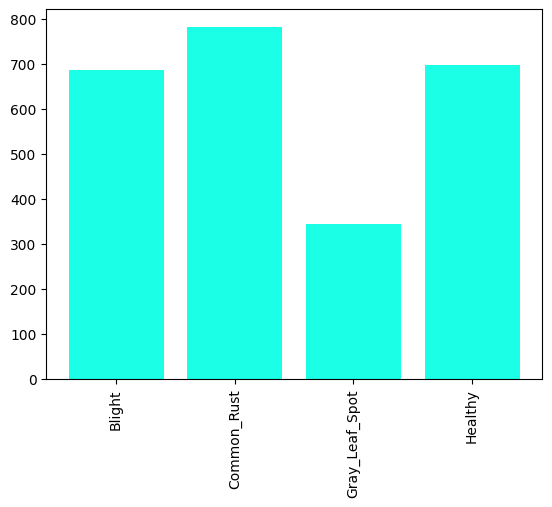

In [7]:
values_counter=Counter(train.classes)
sorted(values_counter.items())
plt.bar(train.class_indices.keys(), values_counter.values(), color=(0.1, 1, 0.9, 1.0))
plt.xticks(rotation=90)
plt.show()

In [8]:
labels=dict()
for label_name,label_num in train.class_indices.items():
        labels[label_num]=label_name

100%|██████████| 15/15 [00:15<00:00,  1.04s/it]


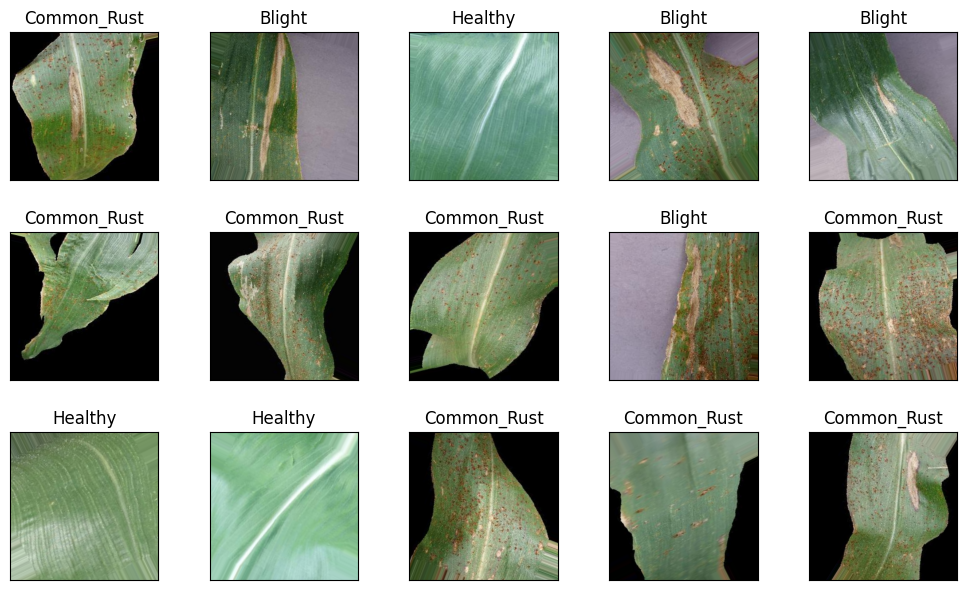

In [9]:
plt.figure(figsize=(10,10))
for i in tqdm(range(15)):
    plt.subplot(5,5,i+1)
    for x_batch,y_batch in train:
        image=x_batch[0]
        argmax=np.argmax(y_batch)
        plt.tight_layout(h_pad=2)
        plt.title(labels[argmax])
        plt.xticks(())
        plt.yticks(())
        plt.imshow(image)
        break

 <div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:200%;
           font-family: Times New Roman, Times, serif;
    letter-spacing:0.5px"><b> Create Model </b></div>

<p style="padding: 10px;color:black;font-size:160%;font-family: Times New Roman, Times, serif;">
I employed GoogleNet as my pre-trained model, unfreezing all layers due to the original data being trained for a different task.

In [11]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, GlobalAveragePooling2D

def configure_model():
    # Change the input shape to (None, None, 3) to match InceptionV3 requirements
    inputs_1 = tf.keras.Input(shape=(None, None, 3))
    x = tf.keras.layers.ZeroPadding2D((3, 3))(inputs_1)
    # Remove the input_shape argument from InceptionV3, as it will adapt to the input shape
    mymodel = InceptionV3(include_top=False, weights='imagenet')
    x = mymodel(inputs_1)
    x = GlobalAveragePooling2D()(x)
    predictors = Dense(4, activation='softmax', name='Predictions')(x)
    final_model = Model(inputs=inputs_1, outputs=predictors)
    return final_model

final_model = configure_model()

# Add the following layers to the model
final_model.layers.append(tf.keras.layers.Dense(10, activation='relu'))
final_model.layers.append(tf.keras.layers.Dense(1, activation='sigmoid'))

def compile_model(model):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

final_model = compile_model(final_model)

In [12]:
def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [13]:
opt=tf.keras.optimizers.Adam(0.0001)
final_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
def callbacks(patience=5):
    checkpoint = tf.keras.callbacks.ModelCheckpoint('my_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
    early=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,min_delta=0.001, restore_best_weights=True)
    lr=tf.keras.callbacks.LearningRateScheduler(scheduler)
    callbacks_list=[checkpoint, early,lr]
    return callbacks_list

In [15]:
callbacks=callbacks()

In [16]:
counter = Counter(train.classes)
max_val = float(max(counter.values()))
class_weights1 = {class_id : max_val/num_images for class_id, num_images in counter.items()}

In [18]:
from tensorflow.keras.regularizers import l2
final_model = tf.keras.models.Sequential(final_model.layers)

In [19]:
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
hist = final_model.fit(train, epochs=30, validation_data=validation, callbacks=callbacks, class_weight=class_weights1)

Epoch 1/30
79/79 [==============================] - ETA: 0s - loss: 0.3061 - accuracy: 0.8148
Epoch 1: val_loss improved from inf to 26.42244, saving model to my_model.h5
79/79 [==============================] - 104s 733ms/step - loss: 0.3061 - accuracy: 0.8148 - val_loss: 26.4224 - val_accuracy: 0.3852 - lr: 0.0010
Epoch 2/30
79/79 [==============================] - ETA: 0s - loss: 0.1799 - accuracy: 0.8937
Epoch 2: val_loss improved from 26.42244 to 3.01480, saving model to my_model.h5
79/79 [==============================] - 59s 745ms/step - loss: 0.1799 - accuracy: 0.8937 - val_loss: 3.0148 - val_accuracy: 0.6328 - lr: 0.0010
Epoch 3/30
79/79 [==============================] - ETA: 0s - loss: 0.1720 - accuracy: 0.8957
Epoch 3: val_loss improved from 3.01480 to 0.27303, saving model to my_model.h5
79/79 [==============================] - 57s 720ms/step - loss: 0.1720 - accuracy: 0.8957 - val_loss: 0.2730 - val_accuracy: 0.7907 - lr: 0.0010
Epoch 4/30
79/79 [=========================

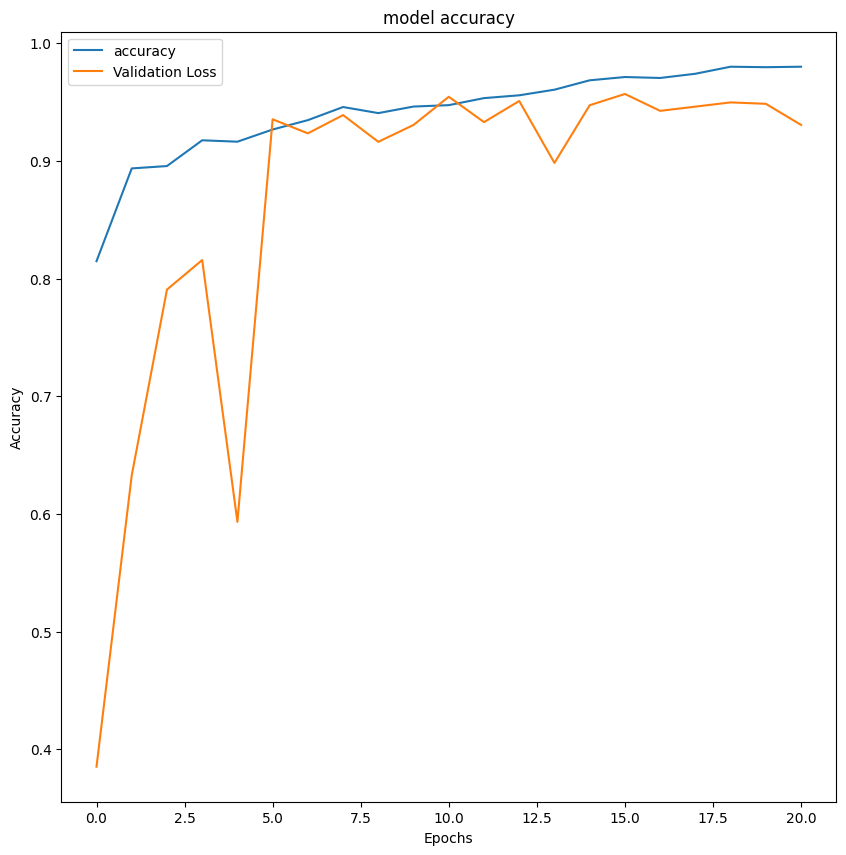

In [21]:
plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["accuracy","Validation Loss"])
plt.show()

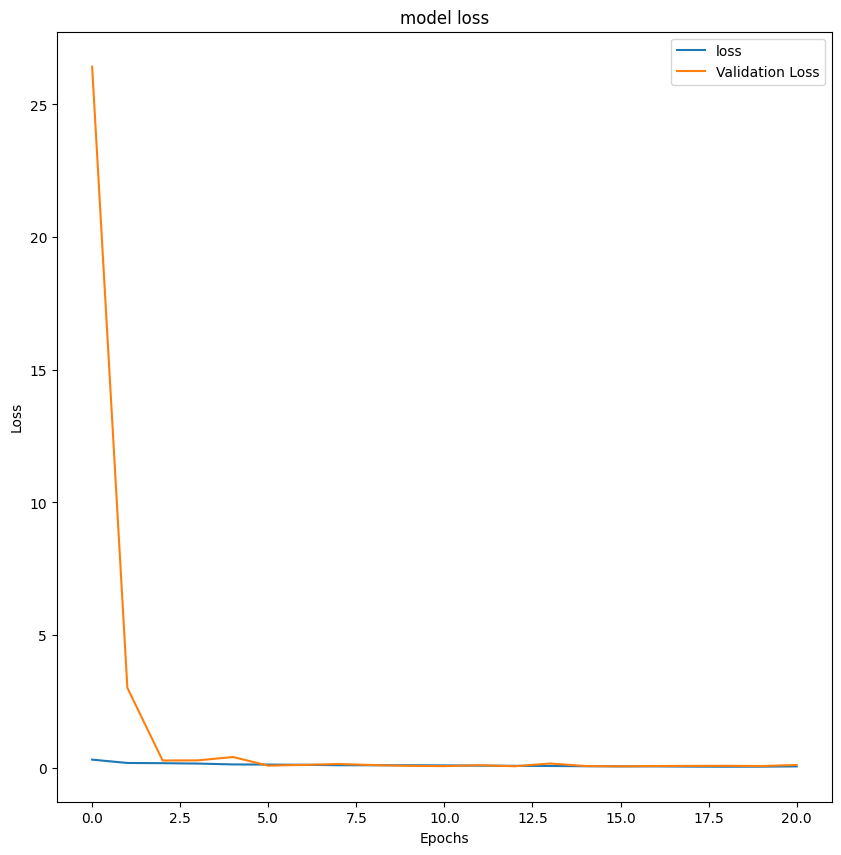

In [22]:
plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["loss","Validation Loss"])
plt.show()

In [23]:
y_real=[]
all_pred=[]
count=0
for x,y in test:
  predict=final_model.predict(x)

  for i in predict:
    all_pred.append(np.argmax(i)+1)
  for i in y:
    i=np.argmax(i)+1
    y_real.append(i)

  if len(y_real)==len(test.filepaths):
    break

1/1 [==============================] - 2s 2s/step


In [24]:
target_names =[]
for key,value in test.class_indices.items():
  target_names.append(f'condition: {key}')

In [25]:
from sklearn import metrics
report=metrics.classification_report(y_real,all_pred,target_names=target_names)
conf_efficnet2=metrics.confusion_matrix(y_real,all_pred)

In [26]:
import itertools
def calculate_final_accuracy(cnf_matrix):
    correct_predictions = np.trace(cnf_matrix)
    total_samples = np.sum(cnf_matrix)
    accuracy = correct_predictions / total_samples
    return accuracy

def plot_confusion_matrix(cnf_matrix, numbers_type='numbers_and_percentage', class_names=target_names, title='Confusion matrix', cmap=plt.cm.Blues, file_name='confusionmatrix.png'):
    combined = True
    cnf_matrix_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = 0.8*cnf_matrix.max() / 1.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        if numbers_type == 'numbers_and_percentage':
            st1 = '{:.2f}%'.format(100 * cnf_matrix_normalized[i, j])
            st2 = '({:2d})'.format(cnf_matrix[i, j])
            plt.text(j, i, st1+st2,
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

        elif numbers_type == 'percentage':
            fmt = '.2f'
            plt.text(j, i, format(cnf_matrix_normalized[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")
        else:
            fmt = 'd'
            plt.text(j, i, format(cnf_matrix[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(file_name)

    return calculate_final_accuracy(cnf_matrix)


0.9631391200951248

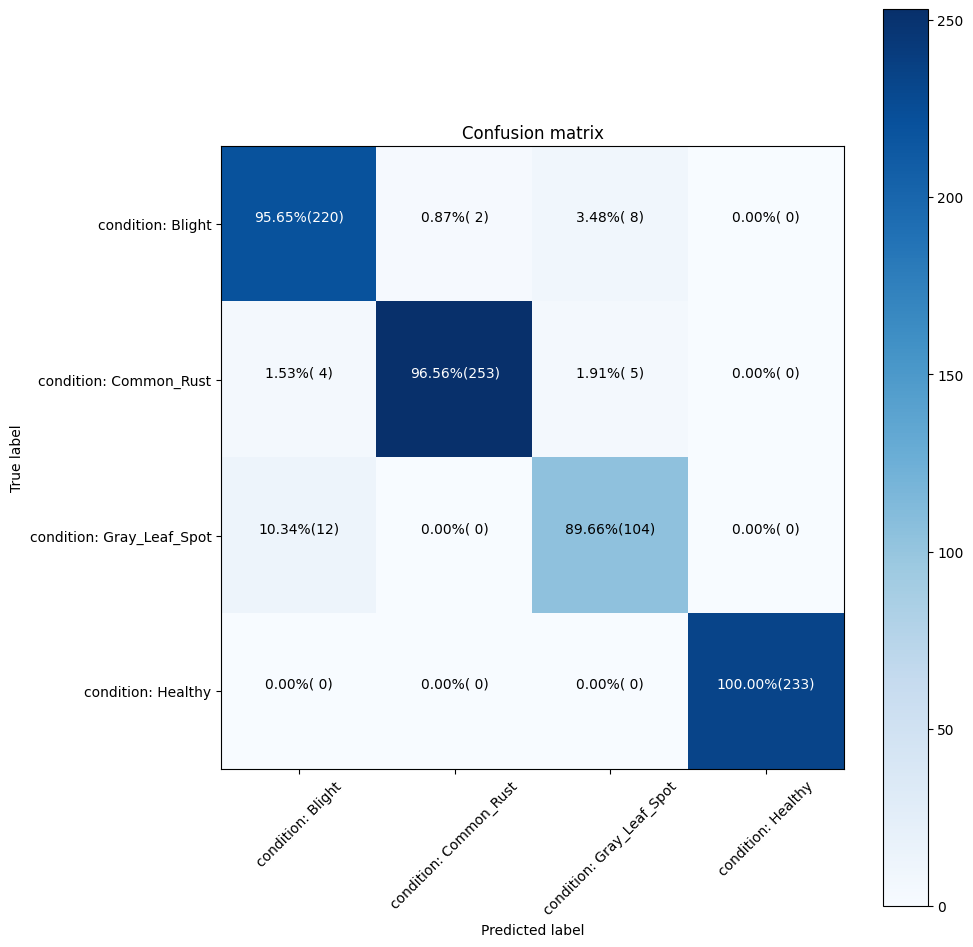

In [28]:
plot_confusion_matrix(conf_efficnet2)


 <div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:200%;
           font-family: Times New Roman, Times, serif;
    letter-spacing:0.5px"><b> Conclusions </b></div>

<p style="padding: 10px;color:black;font-size:160%;font-family: Times New Roman, Times, serif;">
The confusion matrix indicates highly favorable results, showcasing an average accuracy of approximately 99%. This performance suggests the potential use of the model for early detection of diseases.

In [ ]:
!pip install nbconvert

In [ ]:
!jupyter nbconvert --to html /content/Plant_Disease_Identification_With_GoogleNet.ipynb

[NbConvertApp] Converting notebook /content/Plant_Disease_Identification_With_GoogleNet.ipynb to html
[NbConvertApp] Writing 1723315 bytes to /content/Plant_Disease_Identification_With_GoogleNet.html
